# Jake initial fits

In [10]:
# Importing the NDN and a couple other packages
# Hey Jake,
# NDN3 is populated (on the github), and should work exactly like NDN2 — other than the imports, which should be like this:
from __future__ import print_function
from __future__ import division

import os
import h5py
import numpy as np
import tensorflow as tf
import scipy.io as sio           # importing matlab data
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
from copy import deepcopy
import random
import sys
sys.path.append('C:\\Users\\Jake\\Documents\\')
sys.path.append('C:\\Users\\Jake\\Documents\\NDN3')


# sys.path.append('C:\\Users\\Jake\\Dropbox\\Projects\\NDN\\NDN3')

# sys.path.insert(0, '/Users/dbutts/GitCode/NDN3/')
import NDN3.NDN as NDN
import NDNutils as NDNutils
import Utils.DanUtils as DU
#import NDN.HadiUtils as HU
import Utils.NDNplot as NDNplot
output_dir = 'C:\\Users\\Jake\\Dropbox\\Projects\\NDN\\output_dir'
# output_dir = '/Users/dbutts/Code/PyPlay/tensorboard'
print(sys.version)
import sys
print(sys.path)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
['C:\\Users\\Jake\\.conda\\envs\\NDN\\python36.zip', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\DLLs', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib', 'C:\\Users\\Jake\\.conda\\envs\\NDN', '', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Jake\\.ipython', 'C:\\Users\\Jake\\Documents\\', 'C:\\Users\\Jake\\Documents\\NDN3', 'C:\\Users\\Jake\\Documents\\', 'C:\\Users\\Jake\\Documents\\NDN3']


In [2]:
NDN.NDN

NDN3.NDN.NDN

In [7]:

# which_gpu = NDNutils.assign_gpu() # this is for assigning to GPU, but can comment out if not good with your config
# NDNutils.setup_no_gpu()

In [11]:
# Load data
datadir = "C:\\Users\\Jake\\Dropbox\\Projects\\FreeViewing\\Data\\"
fname = "L20191231_Gabor.mat"

dat = sio.loadmat(datadir + fname)
Robs = dat['Robs']
stim = dat['stim']
valdata = dat['valdata']
slist = dat['slist']
xax = dat['xax']
yax = dat['yax']
labels = dat['labels']
dt = dat['dt']
NX = dat['NX']
eyeAtFrame = dat['eyeAtFrame']

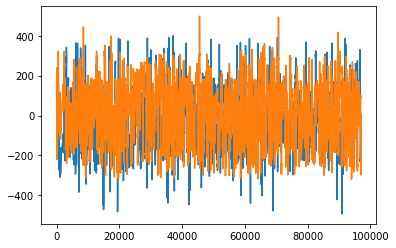

In [4]:
eyeXFrame = eyeAtFrame[:,0]-640
eyeYFrame = eyeAtFrame[:,1]-360
plt.figure
plt.plot(eyeXFrame)
plt.plot(eyeYFrame)

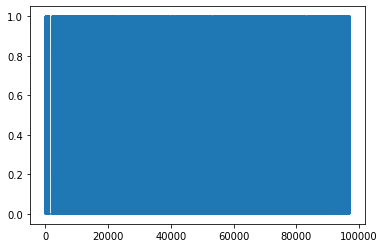

In [5]:
plt.figure()
plt.plot(labels==1)
# import h5py
# f = h5py.File(datadir+fname)
# list(f.keys())

# f['Robs']

In [6]:
# Robs = f['Robs'].value
# stim = f['stim'].value
# valdata = f['valdata'].value
# slist = f['slist'].value
# xax = f['xax'].value
# yax = f['yax'].value
# labels = f['labels'].value
# dt = f['dt'].value
# NX = f['NX'].value

# Robs = Robs.transpose()
# stim = stim.transpose()

In [12]:
sac_beg = slist[0,:]
sac_end = slist[1,:]
NY = int(stim.shape[1]/NX)
NX = int(NX)

fixation = labels[:,0]==1

d2 = np.diff(fixation.astype(int))
fixstart = np.where(d2==1)[0]
fixstop = np.where(d2==-1)[0]
fixation2 = np.zeros(len(fixation))
for i in range(len(fixstart)):
    fixation2[fixstart[i]+2:fixstop[i]]=1
    
np.sum(fixation2==1)

IndexError: index 2244 is out of bounds for axis 0 with size 2244

(array([   10,    33,    54, ..., 82573, 82579, 82638], dtype=int64),)

(81864,)
68342.0
31223


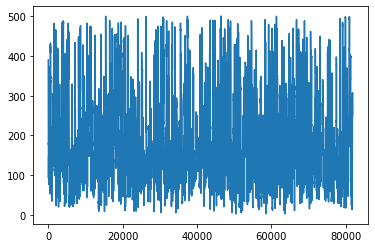

In [15]:

d = np.hypot(eyeXFrame, eyeYFrame)
print(d.shape)

l = np.logical_and(fixation2==1, d<150)
print(np.sum(fixation2))
print(np.sum(l))
# labels==1 & d < 4*37
plt.figure
plt.plot(d)

In [7]:

[NTall,NC] = Robs.shape
print( "%d time steps, %d cells" %(NTall, NC))

val_inds = np.zeros(NTall)

fixation = np.where(l)

for i in range(len(fixation)):
    val_inds[fixation[i]] = 1

used_inds = np.where(val_inds > 0)[0]
NT = len(used_inds)
print(NT, 'valid time points')


96987 time steps, 61 cells


NameError: name 'l' is not defined

In [9]:
print(sum(val_inds))
# Establish train and test indices
Ui, XVi = NDNutils.generate_xv_folds(NT)

0.0


NameError: name 'NT' is not defined

In [18]:
# Fitting parameters for Adam
adam_paramF = {'use_gpu': True}
# adam_paramF = NDN.NDN.optimizer_defaults(opt_params=adam_paramF, learning_alg='adam')

early_stopping = 50

adam_paramF['batch_size'] = NT // 100
# adam_paramF['batch_size'] = 3000
adam_paramF['display'] = 10
adam_paramF['epochs_training'] = early_stopping * 100
adam_paramF['run_diagnostics'] = False

adam_paramF['epsilon'] = 1e-8
adam_paramF['early_stop'] = early_stopping
adam_paramF['early_stop_mode'] = 11
#adam_paramF['data_pipe_type'] = 'iterator'
#adam_paramF['data_pipe_type'] = 'feed_dict'
adam_paramF['data_pipe_type'] = 'data_as_var'
adam_paramF['learning_rate'] = 1e-3

adam_silent = adam_paramF.copy()
adam_silent['display'] = None

## GLM 
Try a simple GLM first

In [19]:
L1reg = 0.0001  # L1  #fit with small L1 and then increase

num_lags = 6 # at 1/2 time resolution -- might be even easier
Xstim = NDNutils.create_time_embedding( stim, [num_lags, NX, NY], tent_spacing=2 )
Xuse = Xstim[used_inds,:].copy()
Ruse = Robs[used_inds,:].copy()
print(Xstim.shape, Xuse.shape)

# glm_par = NDNutils.ffnetwork_params( 
#     input_dims=[1,NP,1], layer_sizes=[NCall], 
#     layer_types=['normal'], act_funcs=['softplus'], 
#     ei_layers=[None], normalization=[0],
#     reg_list={'l1':[L1reg],'max_filt':[None]} )

(81864, 2400) (31223, 2400)


In [20]:
# dimensionality reduction with Nsubs linear subunits that can be combined
Nsub = 6
L1reg = 0.00001
Xreg = .1
Treg = .001

glm_shared_1 = NDNutils.ffnetwork_params(
    input_dims=[num_lags,NX,NY], layer_sizes=[Nsub],
    layer_types=['normal'], act_funcs=['relu'], 
    ei_layers=[None], normalization=[0],
    reg_list={'l1':[L1reg], 'd2x':[Treg], 'd2x':[Xreg],'max_filt':[None]})

glm_shared_2  = NDNutils.ffnetwork_params(xstim_n=[],
    ffnet_n=[0],layer_sizes=[NC],
    layer_types=['normal'], act_funcs=['softplus'])


Input dimensions: [6, 20, 20]
0: normal (relu):  	[E6/I0] 
0: normal (softplus):  	[E35/I0] 


In [42]:
# glm0 = NDN.NDN(glm_base, tf_seed=5)
# _=glm0.train(input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi,
#                 learning_alg='lbfgs', opt_params=adam_paramF)

In [10]:
# DU.plot_filters(glmshare, tbasis_select=3)

In [78]:
glmshare = NDN.NDN([glm_shared_1, glm_shared_2], tf_seed=5)

In [80]:
_=glmshare.train(input_data=np.abs(Xuse.astype('float32')), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi,
                learning_alg='adam', opt_params=adam_paramF)

Epoch 0000:  avg train cost =     7.6452,  avg test cost =     7.6364,  reg penalty =    10.0570
Epoch 0009:  avg train cost =     3.0894,  avg test cost =     3.1399,  reg penalty =     1.5731
Epoch 0019:  avg train cost =     3.0750,  avg test cost =     3.1642,  reg penalty =     0.3267
Epoch 0029:  avg train cost =     3.0387,  avg test cost =     3.1433,  reg penalty =     0.1021
Epoch 0039:  avg train cost =     3.0197,  avg test cost =     3.1422,  reg penalty =     0.0518
Epoch 0049:  avg train cost =     3.0033,  avg test cost =     3.1437,  reg penalty =     0.0373
Epoch 0059:  avg train cost =     3.0105,  avg test cost =     3.1698,  reg penalty =     0.0331
Epoch 0069:  avg train cost =     3.0235,  avg test cost =     3.1652,  reg penalty =     0.0301
Epoch 0079:  avg train cost =     3.0020,  avg test cost =     3.1515,  reg penalty =     0.0300
Epoch 0089:  avg train cost =     2.9679,  avg test cost =     3.1348,  reg penalty =     0.0299

*** early stop criteria met..

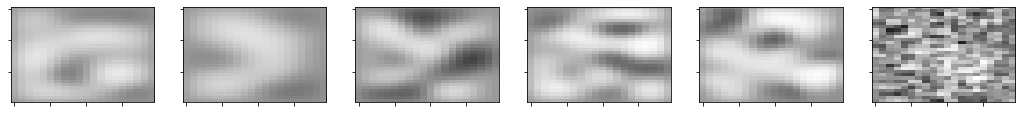

In [81]:

DU.plot_filters(glmshare, tbasis_select=2)

Epoch 0000:  avg train cost =     3.1688,  avg test cost =     3.3054,  reg penalty =     0.0345
Epoch 0009:  avg train cost =     2.9623,  avg test cost =     3.3237,  reg penalty =     0.0513
Epoch 0019:  avg train cost =     2.9126,  avg test cost =     3.3809,  reg penalty =     0.0662
Epoch 0029:  avg train cost =     2.8801,  avg test cost =     3.4009,  reg penalty =     0.0688
Epoch 0039:  avg train cost =     2.8600,  avg test cost =     3.4380,  reg penalty =     0.0738
Epoch 0049:  avg train cost =     2.8455,  avg test cost =     3.4203,  reg penalty =     0.0787

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 51,  end cost: 122.823676
     ---> best epoch: 2,  best cost: 116.179258



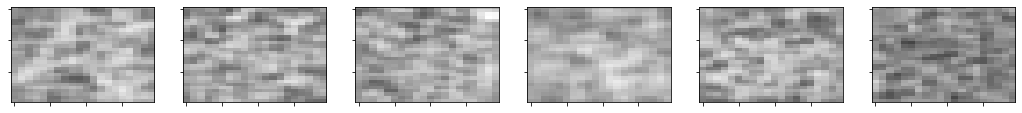

In [84]:
Treg = 0.001
Xreg = .1
# L1reg = .0001
# glmshare.set_regularization('d2x', [Xreg],0,0)
# glmshare.set_regularization('d2t', [Treg],0,0)
# glmshare.set_regularization('l1', [L1reg],0,0)
_=glmshare.train(input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi,
                learning_alg='adam', opt_params=adam_paramF)
# lbfgs
DU.plot_filters(glmshare)

### Define and fit models

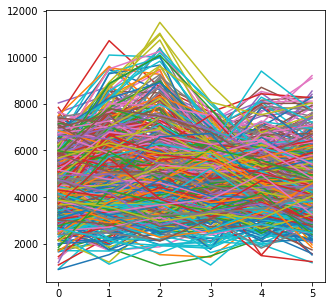

In [85]:
# make sure STA works
sta = np.dot(Xuse.transpose(), Ruse)

plt.figure(figsize=(5,5))
a = np.reshape(sta[:,14], [NX*NY, num_lags])
h = plt.plot(a.transpose());

(3600, 35)


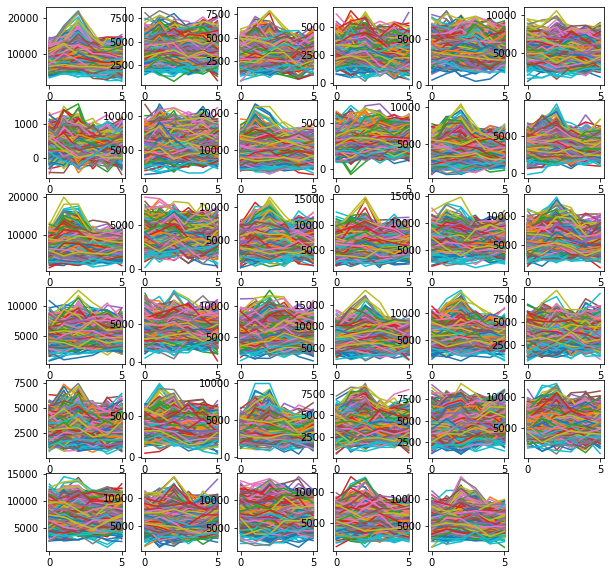

In [86]:
print(sta.shape)
# NDNutils.expand_input_dims_to_3d(sta[])
plt.figure(figsize=(10,10))
sx = int(np.ceil(np.sqrt(NC)))
sy = int(np.round(np.sqrt(NC)))
for i in range(NC):
    plt.subplot(sx,sy,i+1)
    a = np.reshape(sta[:,i], [NX*NY, num_lags])
    plt.plot(a.transpose())
#     plt.imshow(, aspect=1/50)

In [88]:
# Make time separable -- not expected to be more than a couple temporal kernels
num_tkerns = 2
num_subs = 6

Treg = .001  # temporal regularization value (guessing as first pass)
Xreg = .5  # spatial regulatization
L1reg = .0001  # L1x

SHnim_par = NDNutils.ffnetwork_params( 
    input_dims=[num_lags,NX,NY], layer_sizes=[num_tkerns, num_subs, NC], 
    layer_types=['conv', 'normal','normal'], act_funcs=['lin','relu','softplus'], 
    ei_layers=[None,None], normalization=[0,0],  conv_filter_widths = [1],
    reg_list={'d2t':[Treg],'d2x':[None,Xreg],'l1':[None,L1reg],'max_filt':[None,None]} )
SHnim0 = NDN.NDN( [SHnim_par], tf_seed = 5)
#v2f = Iff0b.fit_variables(layers_to_skip=[0,1], fit_biases=True)
#print(v2f)
import time
t0 = time.time()
_= SHnim0.train( input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi, 
    learning_alg='adam', opt_params=adam_paramF) #, output_dir=output_dir+"1") #, fit_variables=v2f)
t1 = time.time()
print(t1-t0, 'elapsed')
LLs = SHnim0.eval_models(input_data=Xuse, output_data=Ruse, data_indxs=XVi) # this is without null-model adjustment
print(np.mean(LLs))

Input dimensions: [6, 30, 20]
0: conv (lin):  	[E2/I0]   	filter width = 1
1: normal (relu):  	[E6/I0] 
2: normal (softplus):  	[E35/I0] 
Epoch 0000:  avg train cost =     4.2626,  avg test cost =     4.1995,  reg penalty =     4.5688
Epoch 0009:  avg train cost =     3.1115,  avg test cost =     3.0896,  reg penalty =     0.0189
Epoch 0019:  avg train cost =     3.0981,  avg test cost =     3.0859,  reg penalty =     0.0068
Epoch 0029:  avg train cost =     3.0921,  avg test cost =     3.0891,  reg penalty =     0.0069
Epoch 0039:  avg train cost =     3.0853,  avg test cost =     3.0916,  reg penalty =     0.0087
Epoch 0049:  avg train cost =     3.0804,  avg test cost =     3.0922,  reg penalty =     0.0106
Epoch 0059:  avg train cost =     3.0714,  avg test cost =     3.0971,  reg penalty =     0.0127

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 59,  end cost: 108.841936
     ---> best epoch: 19,  best cost: 108.245365

117.82619953155518 el

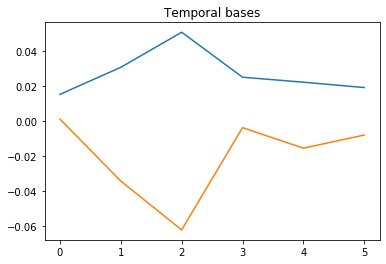

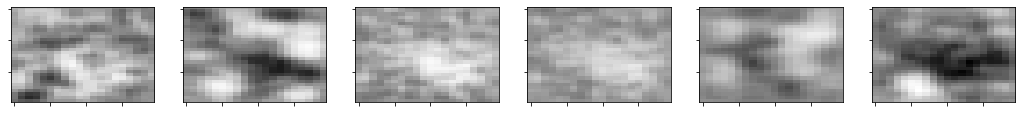

In [89]:
DU.plot_filters(SHnim0,tbasis_select=2)

Can play around with the different configs above. Surprisingly, having fewer temporal kernels hurts. But I play around a lot more below once I try different regularizations systmatically.

In [67]:
SHnim0.set_regularization('l1', .001)
# SHnim0.set_regularization('d2t', .01)
# SHnim0.set_regularization('d2x', .1)


Epoch 0000:  avg train cost =     3.0701,  avg test cost =     3.1819,  reg penalty =     0.0045
Epoch 0009:  avg train cost =     3.0568,  avg test cost =     3.1774,  reg penalty =     0.0115
Epoch 0019:  avg train cost =     3.0346,  avg test cost =     3.1548,  reg penalty =     0.0142
Epoch 0029:  avg train cost =     3.0281,  avg test cost =     3.1574,  reg penalty =     0.0156
Epoch 0039:  avg train cost =     3.0236,  avg test cost =     3.1550,  reg penalty =     0.0157
Epoch 0049:  avg train cost =     3.0206,  avg test cost =     3.1591,  reg penalty =     0.0171
Epoch 0059:  avg train cost =     3.0164,  avg test cost =     3.1613,  reg penalty =     0.0165

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 60,  end cost: 111.525305
     ---> best epoch: 17,  best cost: 110.851152



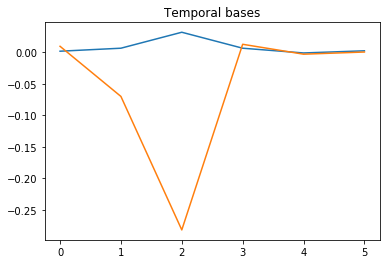

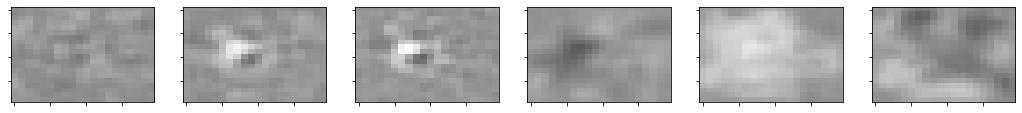

In [60]:
_= SHnim0.train( input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi, 
    learning_alg='adam', opt_params=adam_paramF) #, output_dir=output_dir+"1") #, fit_variables=v2f)
DU.plot_filters(SHnim0)

Epoch 0000:  avg train cost =     3.0170,  avg test cost =     3.1604,  reg penalty =     0.0152
Epoch 0009:  avg train cost =     3.0167,  avg test cost =     3.1697,  reg penalty =     0.0165
Epoch 0019:  avg train cost =     3.0151,  avg test cost =     3.1579,  reg penalty =     0.0163
Epoch 0029:  avg train cost =     3.0144,  avg test cost =     3.1566,  reg penalty =     0.0158
Epoch 0039:  avg train cost =     3.0126,  avg test cost =     3.1588,  reg penalty =     0.0174
Epoch 0049:  avg train cost =     3.0098,  avg test cost =     3.1622,  reg penalty =     0.0174

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 51,  end cost: 111.289899
     ---> best epoch: 40,  best cost: 110.925867



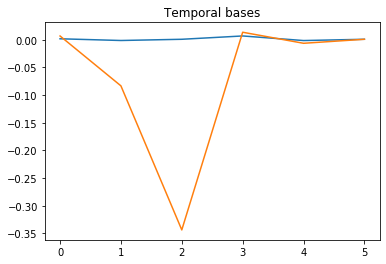

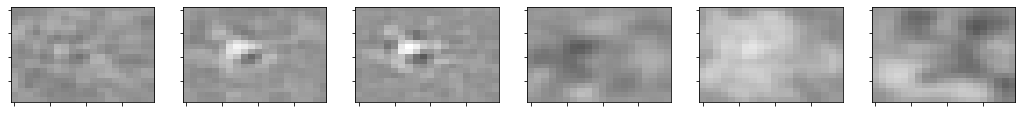

In [61]:
_= SHnim0.train( input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi, 
    learning_alg='adam', opt_params=adam_paramF) #, output_dir=output_dir+"1") #, fit_variables=v2f)
DU.plot_filters(SHnim0)

Epoch 0000:  avg train cost =     3.0010,  avg test cost =     3.1648,  reg penalty =     0.0262
Epoch 0009:  avg train cost =     2.9858,  avg test cost =     3.1790,  reg penalty =     0.0296
Epoch 0019:  avg train cost =     2.9853,  avg test cost =     3.1736,  reg penalty =     0.0307
Epoch 0029:  avg train cost =     2.9759,  avg test cost =     3.1891,  reg penalty =     0.0307
Epoch 0039:  avg train cost =     2.9737,  avg test cost =     3.1794,  reg penalty =     0.0318
Epoch 0049:  avg train cost =     2.9745,  avg test cost =     3.1872,  reg penalty =     0.0322

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 51,  end cost: 112.586508
     ---> best epoch: 3,  best cost: 111.536073



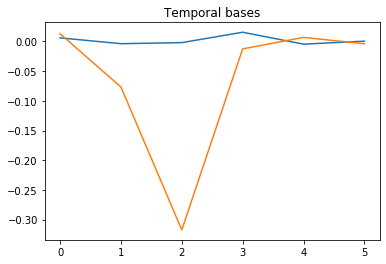

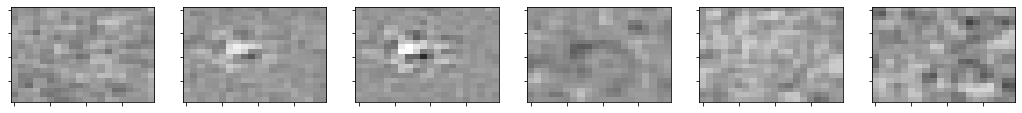

In [80]:
SHnim0.set_regularization('l1', .01, 0,1)
SHnim0.set_regularization('d2x', .1, 0,1)
SHnim1 = SHnim0.copy_model()
_= SHnim1.train( input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi, 
    learning_alg='adam', opt_params=adam_paramF) #, output_dir=output_dir+"1") #, fit_variables=v2f)
DU.plot_filters(SHnim1)

Epoch 0000:  avg train cost =     2.9685,  avg test cost =     3.1924,  reg penalty =     0.0317
Epoch 0009:  avg train cost =     2.9687,  avg test cost =     3.2051,  reg penalty =     0.0323
Epoch 0019:  avg train cost =     2.9745,  avg test cost =     3.2067,  reg penalty =     0.0318
Epoch 0029:  avg train cost =     2.9674,  avg test cost =     3.2068,  reg penalty =     0.0329
Epoch 0039:  avg train cost =     2.9675,  avg test cost =     3.2067,  reg penalty =     0.0333
Epoch 0049:  avg train cost =     2.9663,  avg test cost =     3.2118,  reg penalty =     0.0332

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 51,  end cost: 113.603799
     ---> best epoch: 8,  best cost: 112.668414



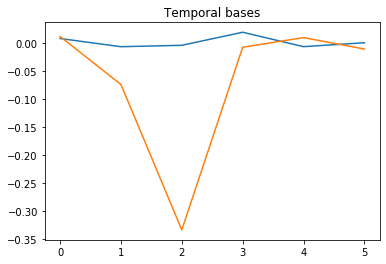

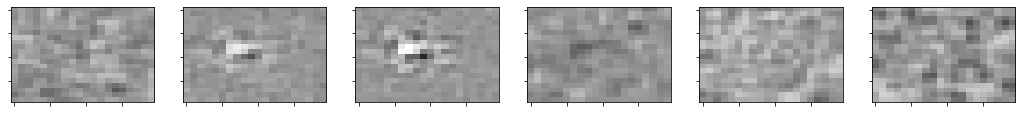

In [81]:
_= SHnim1.train( input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi, 
    learning_alg='adam', opt_params=adam_paramF) #, output_dir=output_dir+"1") #, fit_variables=v2f)
DU.plot_filters(SHnim1)


Epoch 0000:  avg train cost =     3.0375,  avg test cost =     3.1582,  reg penalty =     0.0817
Epoch 0009:  avg train cost =     3.0340,  avg test cost =     3.1489,  reg penalty =     0.0778
Epoch 0019:  avg train cost =     3.0331,  avg test cost =     3.1439,  reg penalty =     0.0758
Epoch 0029:  avg train cost =     3.0313,  avg test cost =     3.1455,  reg penalty =     0.0786
Epoch 0039:  avg train cost =     3.0327,  avg test cost =     3.1438,  reg penalty =     0.0773
Epoch 0049:  avg train cost =     3.0399,  avg test cost =     3.1529,  reg penalty =     0.0813

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 52,  end cost: 113.184097
     ---> best epoch: 35,  best cost: 112.278972



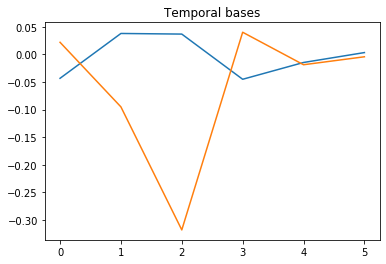

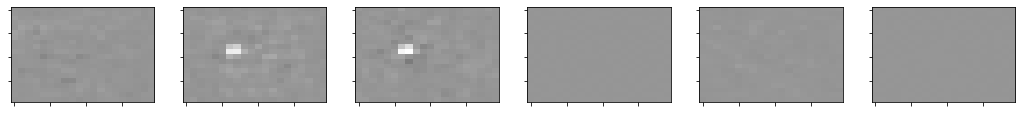

In [95]:
SHnim1.set_regularization('d2x', 1, 0,1)
SHnim1.set_regularization('l1', 1, 0,1)
_= SHnim1.train( input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi, 
    learning_alg='adam', opt_params=adam_paramF) #, output_dir=output_dir+"1") #, fit_variables=v2f)
DU.plot_filters(SHnim1)

0 (d2t = 1e-06): 3.158217
1 (d2t = 0.0001): 3.1577697
2 (d2t = 0.001): 3.1583312
3 (d2t = 0.01): 3.155232
4 (d2t = 0.1): 3.1574452
5 (d2t = 1): 3.1535046


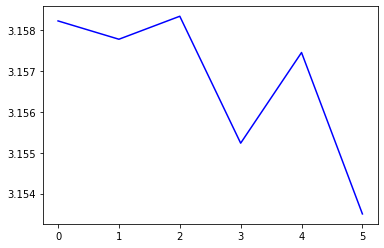

In [91]:
# Try different regularizations
#rvals = [1e-4,0.001,0.01,0.1,1]
RLLsT, RmodsT = DU.reg_path(
    ndn_mod=SHnim0, reg_type='d2t', ffnet_target=0, layer_target=0,
    input_data=Xuse, output_data=Ruse, train_indxs=Ui, test_indxs=XVi, opt_params=adam_paramF)
plt.plot(RLLsT,'b')
plt.show()

0 (d2x = 1e-06): 3.138547
1 (d2x = 0.0001): 3.1385388
2 (d2x = 0.001): 3.1360738
3 (d2x = 0.01): 3.1369286
4 (d2x = 0.1): 3.1387827
5 (d2x = 1): 3.1583312


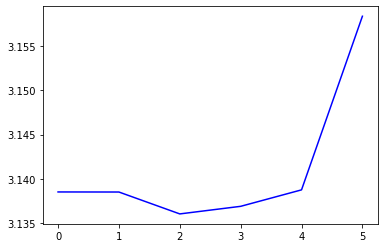

In [92]:
RLLsX, RmodsX = DU.reg_path(
    ndn_mod=SHnim0, reg_type='d2x', ffnet_target=0, layer_target=1,
    input_data=Xuse, output_data=Ruse, train_indxs=Ui, test_indxs=XVi, opt_params=adam_paramF)
plt.plot(RLLsX,'b')
plt.show()

0 (l1 = 1e-06): 3.1664085
1 (l1 = 0.0001): 3.1648939
2 (l1 = 0.001): 3.1664221
3 (l1 = 0.01): 3.1650634
4 (l1 = 0.1): 3.1637335
5 (l1 = 1): 3.1583312


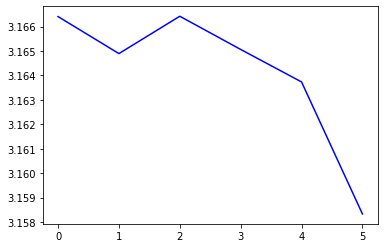

In [93]:
RLLsL, RmodsL = DU.reg_path(
    ndn_mod=SHnim0, reg_type='l1', ffnet_target=0, layer_target=1,
    input_data=Xuse, output_data=Ruse, train_indxs=Ui, test_indxs=XVi, opt_params=adam_paramF)
plt.plot(RLLsL,'b')
plt.show()

In [94]:
# Best reg from reg_paths -- most regularization did not help
Xreg = 0.1
Lreg = .5
Treg = .01

# Now vary the number of subunits
submods = []
LLmods = np.zeros(10)
for nn in range(10):
    num_subs = 2*nn + 4
    SHnim_par = NDNutils.ffnetwork_params( 
        input_dims=[num_lags,NX,NY], layer_sizes=[num_tkerns, num_subs, NC], 
        layer_types=['conv', 'normal','normal'], act_funcs=['lin','relu','softplus'], 
        ei_layers=[None,None], normalization=[1,1],  conv_filter_widths = [1],
        reg_list={'d2t':[None],'d2x':[None,Xreg],'l1':[None,None],'max_filt':[None,None]} )

    reg_mod = NDN.NDN( [SHnim_par], tf_seed = 5)
#v2f = Iff0b.fit_variables(layers_to_skip=[0,1], fit_biases=True)
#print(v2f)

    _= reg_mod.train( input_data=Xuse, output_data=Ruse, train_indxs=Ui, test_indxs=XVi, 
        learning_alg='adam', opt_params=adam_silent, output_dir=output_dir) #, fit_variables=v2f)

    LLmods[nn] = np.mean(reg_mod.eval_models(input_data=Xuse, output_data=Ruse, data_indxs=XVi, nulladjusted=True ))
    print( "%2d  %f" % (num_subs, LLmods[nn]) )
    submods.append(reg_mod.copy_model())

Input dimensions: [6, 20, 20]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E4/I0] N
2: normal (softplus):  	[E35/I0] 


FailedPreconditionError: Failed to remove a directory: C:\Users\Jake\Dropbox\Projects\NDN\output_dir\summaries\train; Directory not empty

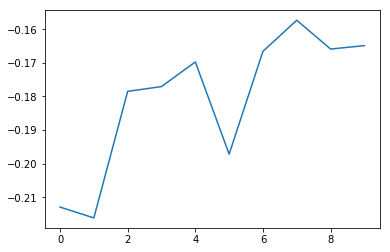

In [125]:
plt.plot(LLmods)
plt.show()

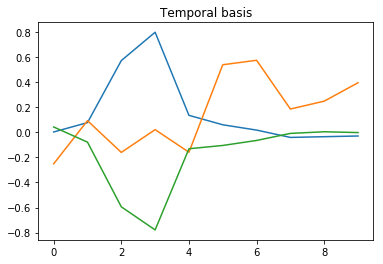

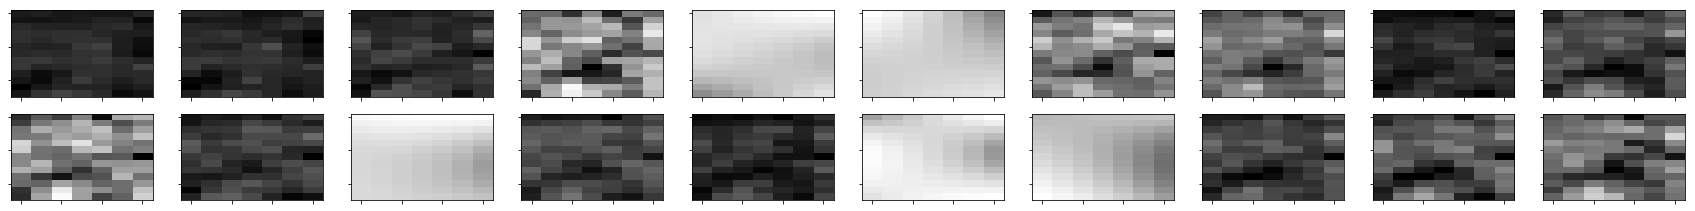

In [116]:
DU.plot_filters(submods[-2])

Not sure what to make of this -- pretty poor regularization

Input dimensions: [10, 13, 7]
0: conv (lin):  	[E4/I0] N  	filter width = 1
1: normal (relu):  	[E4/I0] N
2: normal (softplus):  	[E46/I0] 
MAP estimation early stop mode 1 activated.

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 82,  end cost: 221.128266
     ---> best epoch: 74,  best cost: 221.013968

 4  -0.212859
Input dimensions: [10, 13, 7]
0: conv (lin):  	[E4/I0] N  	filter width = 1
1: normal (relu):  	[E6/I0] N
2: normal (softplus):  	[E46/I0] 
MAP estimation early stop mode 1 activated.

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 82,  end cost: 221.069702
     ---> best epoch: 74,  best cost: 220.941035

 6  -0.216077
Input dimensions: [10, 13, 7]
0: conv (lin):  	[E4/I0] N  	filter width = 1
1: normal (relu):  	[E8/I0] N
2: normal (softplus):  	[E46/I0] 
MAP estimation early stop mode 1 activated.

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 124,  end 

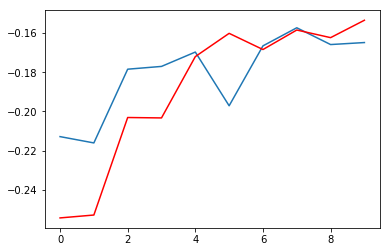

In [117]:
# Best reg from reg_paths
Xreg = 0.01
Lreg = None
Treg = None

# Now vary the number of subunits
num_tkerns = 4
submods = []
LLmods2 = np.zeros(10)
for nn in range(10):
    num_subs = 2*nn + 4
    SHnim_par = NDNutils.ffnetwork_params( 
        input_dims=[num_lags,NX,NY], layer_sizes=[num_tkerns, num_subs, NC], 
        layer_types=['conv', 'normal','normal'], act_funcs=['lin','relu','softplus'], 
        ei_layers=[None,None], normalization=[1,1],  conv_filter_widths = [1],
        reg_list={'d2t':[None],'d2x':[None,Xreg],'l1':[None,None],'max_filt':[None,None]} )

    reg_mod = NDN.NDN( [SHnim_par], tf_seed = 5)
#v2f = Iff0b.fit_variables(layers_to_skip=[0,1], fit_biases=True)
#print(v2f)

    _= reg_mod.train( input_data=Xuse, output_data=Ruse, train_indxs=Ui, test_indxs=XVi, 
        learning_alg='adam', opt_params=adam_silent, output_dir=output_dir) #, fit_variables=v2f)

    LLmods2[nn] = np.mean(reg_mod.eval_models(input_data=Xuse, output_data=Ruse, data_indxs=XVi, nulladjusted=True ))
    print( "%2d  %f" % (num_subs, LLmods[nn]) )
    submods.append(reg_mod.copy_model())
plt.plot(LLmods)
plt.plot(LLmods2,'r')
plt.show()

In [121]:
# Try regularizing last layer with my own sparseness reg (using bigger network)
num_tkerns = 4
num_subs=12
# fit base model
SHnim_par = NDNutils.ffnetwork_params( 
        input_dims=[num_lags,NX,NY], layer_sizes=[num_tkerns, num_subs, NC], 
        layer_types=['conv', 'normal','normal'], act_funcs=['lin','relu','softplus'], 
        ei_layers=[None,None], normalization=[1,1],  conv_filter_widths = [1],
        reg_list={'d2t':[None],'d2x':[None,Xreg],'l1':[None,None],'max_filt':[None,None]} )
base_mod = NDN.NDN( [SHnim_par], tf_seed = 5)
_= base_mod.train( input_data=Xuse, output_data=Ruse, train_indxs=Ui, test_indxs=XVi, 
                  learning_alg='adam', opt_params=adam_paramF, output_dir=output_dir)

Input dimensions: [10, 13, 7]
0: conv (lin):  	[E4/I0] N  	filter width = 1
1: normal (relu):  	[E12/I0] N
2: normal (softplus):  	[E46/I0] 
MAP estimation early stop mode 1 activated.
Epoch 0000:  avg train cost =    52.3541,  avg test cost =    52.4010,  reg penalty =     0.0026
Epoch 0009:  avg train cost =     4.5574,  avg test cost =     4.8325,  reg penalty =     0.0005
Epoch 0019:  avg train cost =     4.5293,  avg test cost =     4.8146,  reg penalty =     0.0003
Epoch 0029:  avg train cost =     4.5235,  avg test cost =     4.8114,  reg penalty =     0.0002
Epoch 0039:  avg train cost =     4.5200,  avg test cost =     4.8083,  reg penalty =     0.0003
Epoch 0049:  avg train cost =     4.5166,  avg test cost =     4.8044,  reg penalty =     0.0003
Epoch 0059:  avg train cost =     4.5109,  avg test cost =     4.7994,  reg penalty =     0.0003
Epoch 0069:  avg train cost =     4.5019,  avg test cost =     4.7881,  reg penalty =     0.0003
Epoch 0079:  avg train cost =     4.490


Regularization test: max = 1e-06:

MAP estimation early stop mode 1 activated.

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 23,  end cost: 217.082597
     ---> best epoch: 22,  best cost: 216.509106

0 (max = 1e-06): 4.718708

Regularization test: max = 0.0001:

MAP estimation early stop mode 1 activated.

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 23,  end cost: 217.089083
     ---> best epoch: 22,  best cost: 216.519114

1 (max = 0.0001): 4.7186775

Regularization test: max = 0.001:

MAP estimation early stop mode 1 activated.

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 23,  end cost: 217.157654
     ---> best epoch: 22,  best cost: 216.596333

2 (max = 0.001): 4.718952

Regularization test: max = 0.01:

MAP estimation early stop mode 1 activated.

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 23,  end cost: 217.498579
  

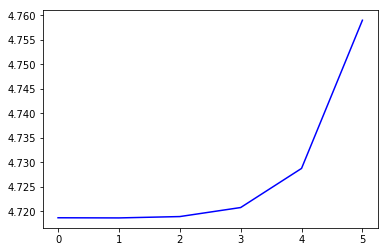

In [123]:
RLLsM, RmodsX = DU.reg_path(
    ndn_mod=base_mod, reg_type='max', ffnet_target=0, layer_target=2,
    input_data=Xuse, output_data=Ruse, train_indxs=Ui, test_indxs=XVi, opt_params=adam_silent)
plt.plot(RLLsM,'b')
plt.show()

This regularization doesn't help either

## Model performance

eval_models gives (potentially) null-adjusted LL per spike for each cell. Thus far I've been taking the mean to look at the performance of the model overall, but now can look at separately. I'm not expecting great things, because the mean is quite negative...

In [132]:
LLs = base_mod.eval_models(input_data=Xuse, output_data=Ruse, data_indxs=XVi, nulladjusted=True) 
print(np.mean(LLs))

-0.16472805


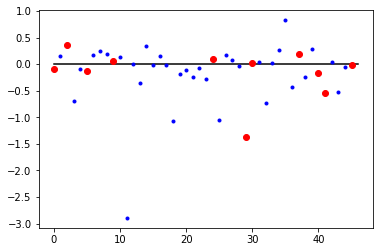

In [133]:
plt.plot([0, len(LLs)],[0,0],'k') # line at zero (null model)
plt.plot(LLs,'b.')
plt.plot(SUlist,LLs[SUlist],'ro') # highlight SUs
plt.show()

this could be optimized for sure for the good neurons, model, etc

### Three layers

In [88]:
# Make time separable -- not expected to be more than a couple temporal kernels
num_tkerns = 2
num_subs1, num_subs2 = 4, 5

Treg = .0001  # temporal regularization value
Xreg = .1001  # spatial regulatization
L1reg = .0001  # L1

nn3_par = NDNutils.ffnetwork_params( 
    input_dims=[num_lags,NX,NY], layer_sizes=[num_tkerns, num_subs1, num_subs2, NC], 
    layer_types=['conv', 'normal','normal', 'normal'], act_funcs=['lin','relu','relu','softplus'], 
    ei_layers=[None,None], normalization=[1,1,1],  conv_filter_widths = [1],
    reg_list={'d2t':[Treg],'d2x':[None,Xreg],'l1':[None,L1reg],'max_filt':[None,None]} )
nn3 = NDN.NDN( [nn3_par], tf_seed = 5)
#v2f = Iff0b.fit_variables(layers_to_skip=[0,1], fit_biases=True)
#print(v2f)

t0 = time.time()
_= nn3.train( input_data=Xuse.astype('float32'), output_data=Ruse.astype('float32'), train_indxs=Ui, test_indxs=XVi, 
    learning_alg='adam', opt_params=adam_paramF) #, fit_variables=v2f)
t1 = time.time()
print(t1-t0, 'elapsed')
LLs3 = nn3.eval_models(input_data=Xuse, output_data=Ruse, data_indxs=XVi, nulladjusted=True)
print(np.mean(LLs), np.mean(LLs3))

Input dimensions: [6, 20, 20]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E4/I0] N
2: normal (relu):  	[E5/I0] N
3: normal (softplus):  	[E35/I0] 
Epoch 0000:  avg train cost =     6.6933,  avg test cost =     6.7297,  reg penalty =     0.1933
Epoch 0009:  avg train cost =     3.2496,  avg test cost =     3.4112,  reg penalty =     0.0553
Epoch 0019:  avg train cost =     3.0941,  avg test cost =     3.2469,  reg penalty =     0.0246
Epoch 0029:  avg train cost =     3.0745,  avg test cost =     3.2160,  reg penalty =     0.0132
Epoch 0039:  avg train cost =     3.0625,  avg test cost =     3.2124,  reg penalty =     0.0105
Epoch 0049:  avg train cost =     3.0499,  avg test cost =     3.2066,  reg penalty =     0.0110
Epoch 0059:  avg train cost =     3.0411,  avg test cost =     3.2075,  reg penalty =     0.0113
Epoch 0069:  avg train cost =     3.0313,  avg test cost =     3.2044,  reg penalty =     0.0115
Epoch 0079:  avg train cost =     3.0253,  avg test co

Helps a little, maybe

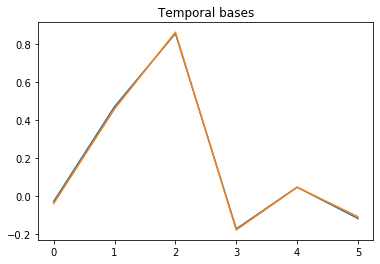

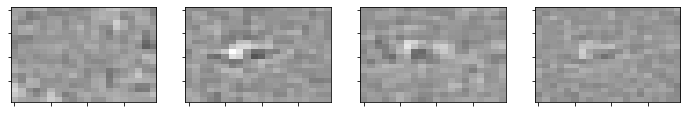

In [89]:
DU.plot_filters(nn3, tbasis_select=2)